# **block2vec**

## Why block2vec

To make blocks continuous so that backprop is possible, we use vector representation of blocks rather than descrete block types. inspired by word2vec [cite], we use a similar technique called block2vec proposed in [world gan paper]. 

World GAN and block2vec code: https://github.com/Mawiszus/World-GAN

In [11]:
# import stuff
import data_helper
import visualise_helper
import numpy as np

import importlib
importlib.reload(visualise_helper)
importlib.reload(data_helper)

<module 'data_helper' from '/Users/leonlu-m1/Documents/Python Programming/3D-GANCA/data_helper.py'>

In [67]:
trainx_df = data_helper.all_trainx_as_df()

  0%|          | 0/1977 [00:00<?, ?it/s]

loaded 1977 houses


In [68]:
trainx_df.head(3)

,world,dir,Size,Num unique IDs,Num unique blocks,Percentage air untrimmed,Percentage air trimmed
0,"[[[[0 0], [0 0], [0 0], [0 0], [0 0], [0 0], [...",workdir.2018-08-27-02:34:57.ip-172-31-11-175,23.0,4.0,7.0,0.955618,0.720497
1,"[[[[0 0], [0 0], [0 0], [0 0], [0 0], [0 0], [...",workdir.2018-08-26-18:49:04.ip-172-31-10-229,15.0,13.0,21.0,0.789630,0.561728
2,"[[[[0 0], [0 0], [0 0], [0 0], [0 0], [0 0], [...",workdir.2018-08-28-02:26:04.ip-172-31-14-122,9.0,9.0,16.0,0.786008,0.646259


  0%|          | 0/3 [00:00<?, ?it/s]

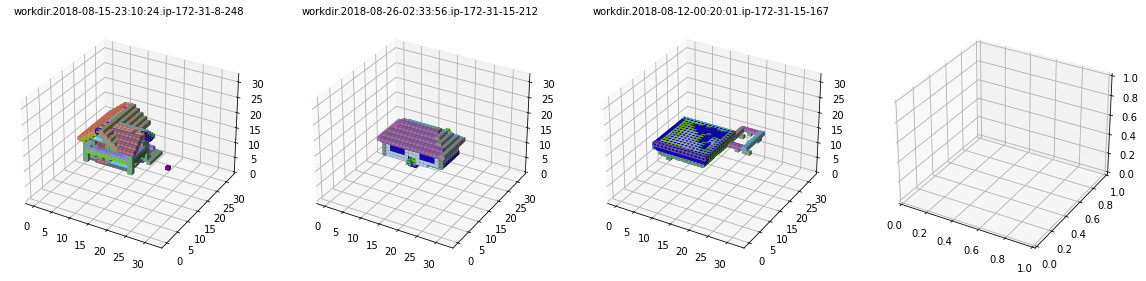

In [69]:
visualise_helper.visualise_world(trainx_df.sample(3))

## pyanvil

In [70]:
from PyAnvilEditor.pyanvil import World, BlockState
opened_world = World('dataset/minecraft_worlds/1_17 m1 test', save_location=None, write=False, debug=False)

In [71]:
opened_world

In [72]:
opened_world.get_chunk((0,0))

In [73]:
opened_world.chunks

{(0, 0): <PyAnvilEditor.pyanvil.world.Chunk at 0x7f818b9bd3d0>}

In [74]:
str(opened_world.get_block((45,40,23)))

'Block(BlockState(minecraft:iron_ore, {}), 0, 0)'

In [75]:
for height in range(100):
    print(str(opened_world.get_block((45,height,23))))

Block(BlockState(minecraft:bedrock, {}), 0, 0)
Block(BlockState(minecraft:bedrock, {}), 0, 0)
Block(BlockState(minecraft:bedrock, {}), 0, 0)
Block(BlockState(minecraft:deepslate, {'axis': 'y'}), 0, 0)
Block(BlockState(minecraft:deepslate, {'axis': 'y'}), 0, 0)
Block(BlockState(minecraft:stone, {}), 0, 0)
Block(BlockState(minecraft:stone, {}), 0, 0)
Block(BlockState(minecraft:stone, {}), 0, 0)
Block(BlockState(minecraft:stone, {}), 0, 0)
Block(BlockState(minecraft:stone, {}), 0, 0)
Block(BlockState(minecraft:stone, {}), 0, 0)
Block(BlockState(minecraft:dirt, {}), 0, 0)
Block(BlockState(minecraft:dirt, {}), 0, 0)
Block(BlockState(minecraft:dirt, {}), 0, 0)
Block(BlockState(minecraft:stone, {}), 0, 0)
Block(BlockState(minecraft:stone, {}), 0, 0)
Block(BlockState(minecraft:stone, {}), 0, 0)
Block(BlockState(minecraft:stone, {}), 0, 0)
Block(BlockState(minecraft:stone, {}), 0, 0)
Block(BlockState(minecraft:stone, {}), 0, 0)
Block(BlockState(minecraft:stone, {}), 0, 0)
Block(BlockState(minec

## Nope try another giant mess

### Import

In [1]:
import os
import sys
import math
import pickle

import numpy as np
import pandas as pd
from typing import Tuple
import data_helper
import importlib
from einops import rearrange
from collections import defaultdict
from itertools import product
from tqdm.notebook import tqdm


from loguru import logger
logger.remove()
logger.add(sys.stdout, colorize=True, format="<blue>{time}</blue> <level>{message}</level>")
logger.level("INFO", color="<red><bold>")

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import init
from torchviz import make_dot
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

### SkipGram

In [2]:
class SkipGramModel(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.target_embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.output = nn.Linear(embedding_dim, num_embeddings)

        initrange = 1.0 / self.embedding_dim
        init.uniform_(self.target_embeddings.weight.data, -
                      initrange, initrange)

    def forward(self, target, context):
        emb_target = self.target_embeddings(target)
        # print('current embedding: ', testskipgrammodel.target_embeddings.weight)

        score = self.output(emb_target)
        # print('score: ', score)
        score = F.log_softmax(score, dim=-1)
        # print('softmax score: ', score)

        losses = torch.stack([F.nll_loss(score, context_word)
                              for context_word in context.transpose(0, 1)])
        return losses.mean()

In [3]:
testskipgrammodel = SkipGramModel(num_embeddings=3, embedding_dim=3)

In [4]:
print(testskipgrammodel)

SkipGramModel(
  (target_embeddings): Embedding(3, 3)
  (output): Linear(in_features=3, out_features=3, bias=True)
)


In [121]:
sample_target = torch.tensor([[0, 1, 0], [0, 0, 1]])
sample_context = torch.tensor([[[1,0,0], [1,0,0], [0,0,1], [1,0,0]], [[1,0,0], [1,0,0], [0,1,0], [1,0,0]]])

with torch.no_grad():
    out = testskipgrammodel.forward(sample_target, sample_context)
    print(out)

writer.add_graph(testskipgrammodel, (sample_target, sample_context))

tensor(1.1388)


/var/folders/tt/63g2nkx15fl855gr711x66540000gn/T/ipykernel_91893/266968691.py:22: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  losses = torch.stack([F.nll_loss(score, context_word)


In [125]:
torch.save(testskipgrammodel, 'testskipgrammodel.pt')

### Minecraft ID dic

In [427]:
import pandas as pd
def gen_block_id_lookup_dict():
    mc_block_database = pd.read_csv('block_ids_alt.tsv', sep='\t')
    mc_block_database = mc_block_database.filter(items=['numerical id', 'item id'])
    mc_block_database = mc_block_database.dropna(subset=["numerical id"])
    mc_block_database
    return mc_block_database.set_index('numerical id').to_dict()['item id'], mc_block_database

In [428]:
gen_block_id_lookup_dict()[1]

,numerical id,item id
0,0,minecraft:air
1,1,minecraft:stone
2,1:1,minecraft:stone
3,1:2,minecraft:stone
4,1:3,minecraft:stone
...,...,...
714,2263,minecraft:record_stal
715,2264,minecraft:record_strad
716,2265,minecraft:record_ward
717,2266,minecraft:record_11


### Dataset

#### Investivate existing

Let's try the original block2vec dataset from the World-GAN paper and see its structure

In [342]:
# try the original block2vec dataset?

from torch.utils.data.dataset import Dataset
import os
from collections import defaultdict
from itertools import product
from typing import Tuple, List

import numpy as np
from tqdm.notebook import tqdm

import sys
sys.path.append(os.path.abspath(".."))
from PyAnvilEditor.pyanvil import World


In [ ]:
class Block2VecDataset(Dataset):

    def __init__(self, input_world_path: str, coords: List[Tuple[int, int]], cutout_coords: bool,  neighbor_radius: int = 1):
        """Block dataset with configurable neighborhood radius.

        Args:
            input_world_path (str): path to the Minecraft world
            coords (Tuple[Tuple[int, int], Tuple[int, int], Tuple[int, int]]): x, y, z coordinates of extracted region
            neighbor_radius (int): neighbors to retrieve as a context
        """
        super().__init__()
        self.input_world_path = input_world_path
        self.world = World(os.path.basename(input_world_path),
                           save_location=os.path.abspath(os.path.dirname(input_world_path)), write=False, debug=False)
        self.x_lims, self.y_lims, self.z_lims = coords if cutout_coords else self._read_size()
        padding = 2 * neighbor_radius  # one token on each side
        self.x_dim = self.x_lims[1] - self.x_lims[0] - padding
        self.y_dim = self.y_lims[1] - self.y_lims[0] - padding
        self.z_dim = self.z_lims[1] - self.z_lims[0] - padding
        logger.info("Cutting {} x {} x {} volume from {}", self.x_dim,
                    self.y_dim, self.z_dim, self.input_world_path)
        self.neighbor_radius = neighbor_radius
        self._read_blocks()
        self._init_discards()

    def _init_discards(self):
        t = 0.001
        token_frequencies = list(self.block_frequency.values())
        f = np.array(token_frequencies) / sum(token_frequencies)
        self.discards = 1.0 - (np.sqrt(f / t) + 1) * (t / f)

    def _read_size(self):
        regions = os.listdir(self.world.world_folder / 'region')
        arr_regions = np.zeros((len(regions), 2))
        for i, r in enumerate(regions):
            name = r.split(".")
            rx = int(name[1])
            rz = int(name[2])
            arr_regions[i] = rx, rz
        igno_border = 0
        x_lims = [int((min(arr_regions[:, 0]) * 32 * 16) + igno_border),
                  int((max(arr_regions[:, 0]) * 32 * 16) - igno_border)]
        z_lims = [int((min(arr_regions[:, 1]) * 32 * 16) + igno_border),
                  int((max(arr_regions[:, 1]) * 32 * 16) - igno_border)]
        y_lims = [0, 256]
        return x_lims, y_lims, z_lims

    def _read_blocks(self):
        self.block_frequency = defaultdict(int)
        coordinates = [(x, y, z) for x, y, z in product(range(self.x_lims[0], self.x_lims[1] + 1),
                                                        range(self.y_lims[0], self.y_lims[1] + 1), range(self.z_lims[0], self.z_lims[1] + 1))]
        logger.info("Collecting {} blocks", len(self))
        for name in tqdm([self._get_block(*coord) for coord in coordinates]):
            self.block_frequency[name] += 1
        logger.info(
            "Found the following blocks {blocks}", blocks=dict(self.block_frequency))
        self.block2idx = dict()
        self.idx2block = dict()
        for name, count in self.block_frequency.items():
            block_idx = len(self.block2idx)
            self.block2idx[name] = block_idx
            self.idx2block[block_idx] = name

    def __getitem__(self, index):
        coords = self._idx_to_coords(index)
        block = self._get_block(*coords)
        target = self.block2idx[block]
        if np.random.rand() < self.discards[target]:
            return self.__getitem__(np.random.randint(self.__len__()))
        neighbor_blocks = self._get_neighbors(*coords)
        context = np.array([self.block2idx[n] for n in neighbor_blocks])
        return target, context

    def _idx_to_coords(self, index):
        z = index % (self.z_dim + 1)
        y = int(((index - z) / (self.z_dim + 1)) % (self.y_dim + 1))
        x = int(((index - z) / (self.z_dim + 1) - y) / (self.y_dim + 1))
        x += self.x_lims[0] + self.neighbor_radius
        y += self.y_lims[0] + self.neighbor_radius
        z += self.z_lims[0] + self.neighbor_radius
        return x, y, z

    def _get_block(self, x, y, z):
        block = self.world.get_block([x, y, z])
        name = block.get_state().name
        return name

    def _get_neighbors(self, x, y, z):
        neighbor_coords = [(x + x_diff, y + y_diff, z + z_diff) for x_diff, y_diff, z_diff in product(list(
            range(-self.neighbor_radius, self.neighbor_radius + 1)), repeat=3) if x_diff != 0 or y_diff != 0 or z_diff != 0]
        return [self._get_block(*coord) for coord in neighbor_coords]

    def __len__(self):
        return self.x_dim * self.y_dim * self.z_dim

In [227]:
class Block2VecArgs:
    
    # the input world?
    input_world_path: str = os.path.abspath('dataset/minecraft_worlds/Drehmal v2.1.1 PRIMORDIAL minified')
    
    # output path?
    output_path: str = os.path.join("output", "block2vec")
    emb_dimension: int = 32
    epochs: int = 30
    batch_size: int = 256 # was 256
    initial_lr: float = 1e-3
    world_coords_name: str = "ruins"
    output_path = os.path.join(output_path, world_coords_name)
    input_world_coords: Tuple[Tuple[int, int], Tuple[int, int], Tuple[int, int]] = (
        (0, 0 + 16),
        (0, 0 + 16),
        (0, 0 + 16),
    )
    
    # input_world_coords = SAMPLE_COORDS[world_coords_name] # use the world_coords_name to key out coord
    
    cutout_coords: bool = True # use input_world_coords rather than the whole world 
    neighbor_radius: int = 1

    logger.info(output_path)

2022-02-12 17:48:52.196 | INFO     | __main__:Block2VecArgs:25 - output/block2vec/ruins


In [228]:
testargs = Block2VecArgs()

In [229]:
testloadworld = Block2VecDataset(testargs.input_world_path, testargs.input_world_coords, testargs.cutout_coords, testargs.neighbor_radius)

2022-02-12 17:49:08.027 | INFO     | __main__:__init__:36 - Cutting 14 x 14 x 14 volume from /Users/leonlu-m1/Documents/Python Programming/3D-GANCA/dataset/minecraft_worlds/Drehmal v2.1.1 PRIMORDIAL minified
2022-02-12 17:49:08.029 | INFO     | __main__:_read_blocks:68 - Collecting 2744 blocks


Epoch 0:   0%|          | 0/1 [05:10<?, ?it/s]


100%|██████████| 4913/4913 [00:00<00:00, 3053736.74it/s]
2022-02-12 17:49:08.624 | INFO     | __main__:_read_blocks:71 - Found the following blocks {'minecraft:bedrock': 289, 'minecraft:stone': 3810, 'minecraft:coal_ore': 24, 'minecraft:granite': 37, 'minecraft:air': 163, 'minecraft:water': 27, 'minecraft:iron_ore': 26, 'minecraft:redstone_ore': 18, 'minecraft:diorite': 443, 'minecraft:lava': 5, 'minecraft:gravel': 60, 'minecraft:diamond_ore': 2, 'minecraft:gold_ore': 3, 'minecraft:emerald_ore': 2, 'minecraft:lapis_ore': 3, 'minecraft:dirt': 1}


In [245]:
testloadworld_dataloader = DataLoader(testloadworld)
len(testloadworld_dataloader)

2744

In [235]:
testloadworld_dataiter = iter(testloadworld_dataloader)

In [254]:
for i in range(5):
  data = testloadworld_dataiter.next()
  print(data)

[tensor([1]), tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 8, 8, 1, 8, 8, 1,
         1, 8]])]
[tensor([1]), tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]])]
[tensor([1]), tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]])]
[tensor([1]), tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]])]
[tensor([6]), tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]])]


#### Exploration

build own? First load all the houses

In [713]:
import data_helper
import importlib
from einops import rearrange
importlib.reload(data_helper)

<module 'data_helper' from '/Users/leonlu-m1/Documents/Python Programming/3D-GANCA/data_helper.py'>

In [612]:
trainx_df = data_helper.all_trainx_as_df()# [:100] # only take first 100 for now
example_houses = trainx_df['world']
example_houses = np.stack(example_houses, axis=0)
example_houses.shape

  0%|          | 0/1977 [00:00<?, ?it/s]

loaded 1977 houses


(1977, 32, 32, 32, 2)

actually want data for skipgram

1. Put all worlds together into giant world
2. make dictionary for unique blocks
3. calculate frequency of blocks and print
4. go through each block and get context

In [659]:
combined_world = rearrange(example_houses, 'n x y z b -> (n x) y z b')
combined_world = combined_world[:,:,:,0]
combined_world.shape

(63264, 32, 32)

In [714]:
def get_block(x, y, z):
    return combined_world[x][y][z]

def get_get_neighbors(x, y, z, neighbor_radius=1):
    neighbor_coords = [(x + x_diff, y + y_diff, z + z_diff) for x_diff, y_diff, z_diff in product(list(range(-neighbor_radius, neighbor_radius + 1)), repeat=3) if x_diff != 0 or y_diff != 0 or z_diff != 0]
    return neighbor_coords

def read_size(world, neighbor_radius=1):
    return [neighbor_radius, world.shape[0] - neighbor_radius - 1], [neighbor_radius, world.shape[1] - neighbor_radius - 1], [neighbor_radius, world.shape[2] - neighbor_radius - 1]

def gen_coords(x_lims, y_lims, z_lims):
    return [(x, y, z) for x, y, z in product(range(x_lims[0], x_lims[1] + 1), range(y_lims[0], y_lims[1] + 1), range(z_lims[0], z_lims[1] + 1))]

In [715]:
get_block(4,5,6)

0

In [716]:
get_get_neighbors(2,4,3, neighbor_radius=1)[1], len(get_get_neighbors(0,0,0, neighbor_radius=1))

((1, 3, 3), 26)

In [717]:
read_size(combined_world, neighbor_radius=1)

([1, 63262], [1, 30], [1, 30])

In [631]:
# get dic for blocks
block_id_lookup_dict, _ = gen_block_id_lookup_dict()
block_frequency = defaultdict(int)
coordinates_to_track = gen_coords(*read_size(combined_world, neighbor_radius=0))
for coord in tqdm(coordinates_to_track):
    numerical_id = get_block(coord[0], coord[1], coord[2])
    # treating all meta of same id the same for simplicity
        
    item_id = block_id_lookup_dict[str(numerical_id)]
        
    block_frequency[item_id] += 1

block2idx = dict()
idx2block = dict()
for name, count in block_frequency.items():
    block_idx = len(block2idx)
    block2idx[name] = block_idx
    idx2block[block_idx] = name
with open('block2idx.pkl', 'wb') as f:
    pickle.dump(block2idx, f)
with open('idx2block.pkl', 'wb') as f:
    pickle.dump(idx2block, f)

  0%|          | 0/64782336 [00:00<?, ?it/s]

In [641]:
with open('block2idx.pkl', 'rb') as f:
    block2idx = pickle.load(f)
with open('idx2block.pkl', 'rb') as f:
    idx2block = pickle.load(f)

In [632]:
block_frequency_dict = dict(block_frequency)

keys = list(block_frequency_dict.keys())
vals = [block_frequency_dict[k] for k in keys]
print(sum(vals))

block_frequency_df = pd.DataFrame({'block id': keys, 'frequency': vals})
block_frequency_df = block_frequency_df.sort_values('frequency', ascending=False)
block_frequency_df

64782336


,block id,frequency
0,minecraft:air,63609606
1,minecraft:planks,244408
44,minecraft:stone,52799
21,minecraft:concrete,45330
66,minecraft:quartz_block,44205
...,...,...
215,minecraft:gray_shulker_box,8
160,minecraft:magenta_glazed_terracotta,6
162,minecraft:detector_rail,4
199,minecraft:nether_wart,4


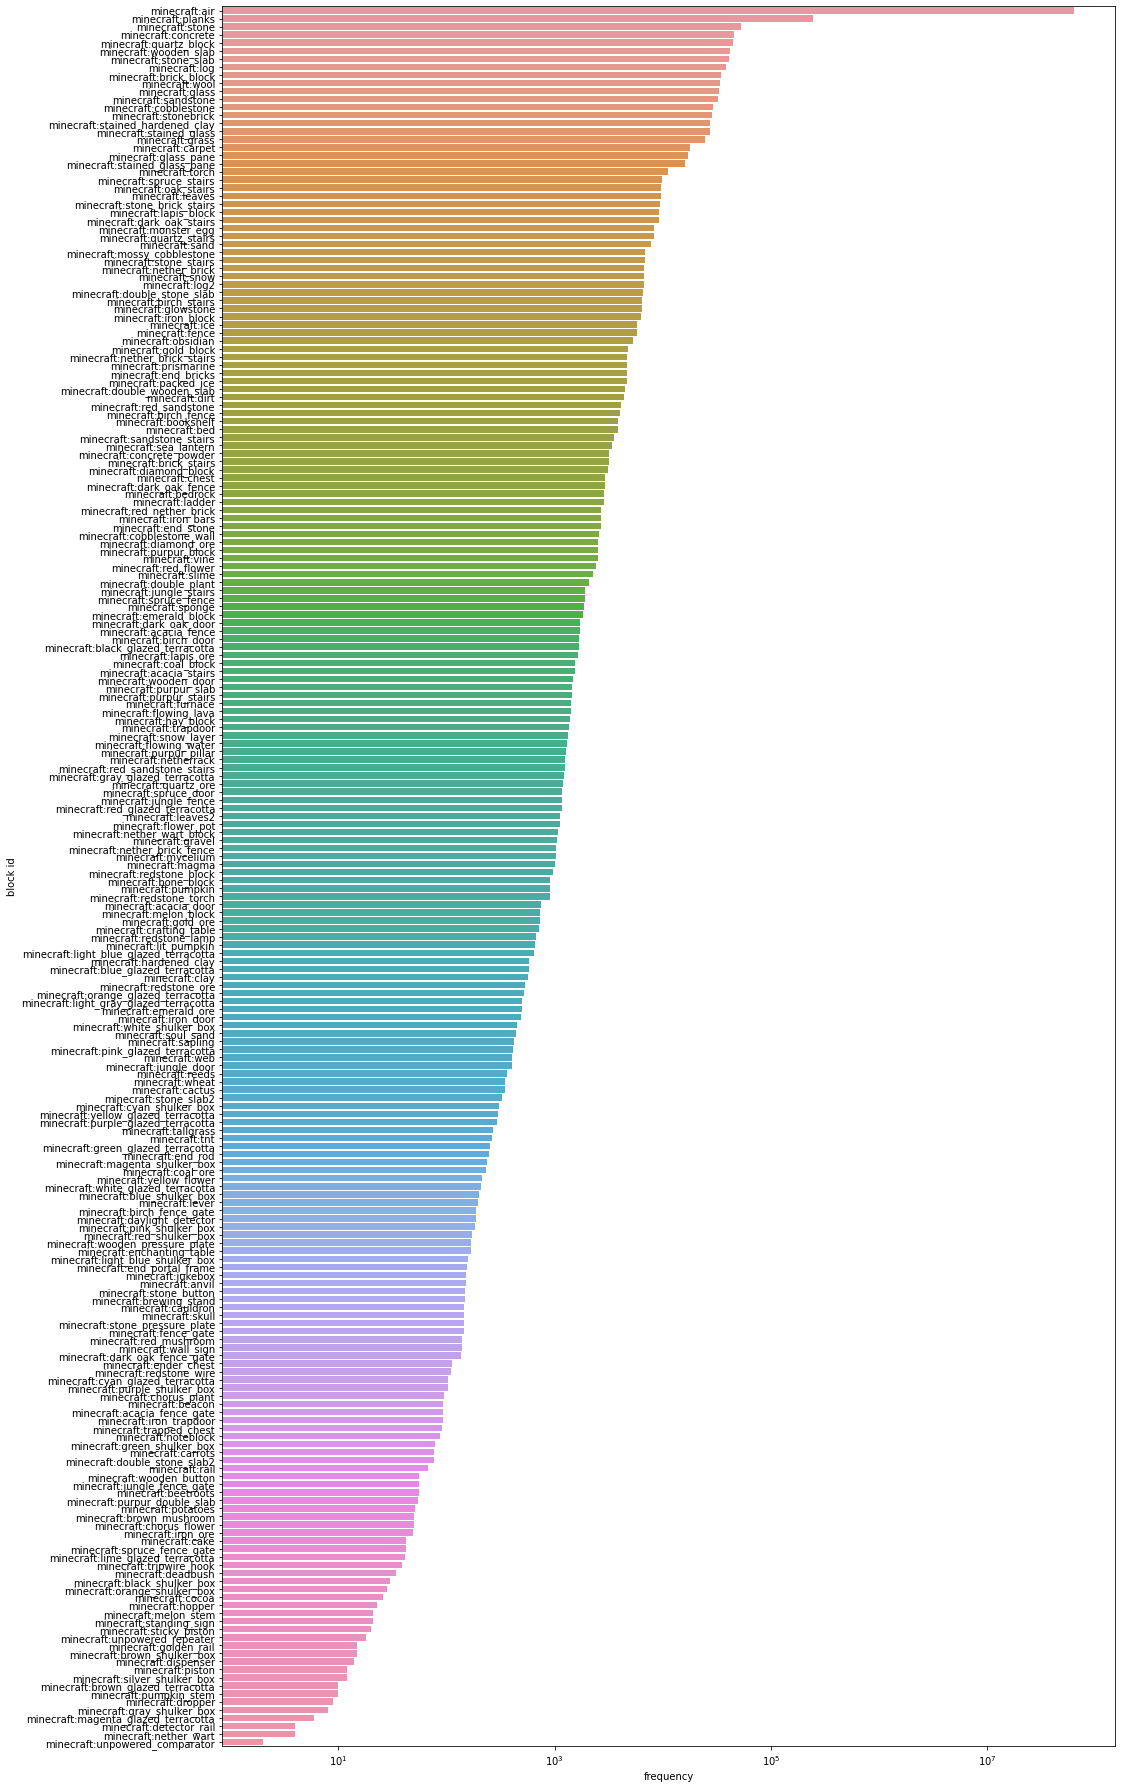

In [634]:
plt.figure(figsize=(16, 32))

import seaborn as sns
ax = sns.barplot(x="frequency", y="block id", data=block_frequency_df,)
ax.set(xscale="log")
plt.show()

#### Create set

Now we need to go through each block and grab context as training data

In [3]:
class Block2VecDataset(Dataset):
    def __init__(self, neighbor_radius = 1, block_ids_table_path='block_ids_alt.tsv'):
        super().__init__()
        self.neighbor_radius = neighbor_radius
        self.block_ids_table_path = block_ids_table_path
        
        self._gen_block_id_lookup_dict()
        self._read_blocks()
        
        padding = 2 * self.neighbor_radius  # one token on each side
        self.x_dim = self.x_lims[1] - self.x_lims[0] + 1 - padding
        self.y_dim = self.y_lims[1] - self.y_lims[0] + 1 - padding
        self.z_dim = self.z_lims[1] - self.z_lims[0] + 1 - padding

        # assuming 32*32*32
        # print(self._idx_to_coords(0)) # lower bound
        # print(self._idx_to_coords(1799)) # should be 2, 30, 30
        # print(self._idx_to_coords(26999)) # upper bound
        
        # print(self._get_neighbors(42,5,5, neighbor_radius=self.neighbor_radius))
        
        # print(self._getitem(3))
        # print(self._getitem(35))
        # print(self._getitem(355))
    
    def _read_size(self, world, neighbor_radius=1):
        return [neighbor_radius, world.shape[0] - neighbor_radius - 1], [neighbor_radius, world.shape[1] - neighbor_radius - 1], [neighbor_radius, world.shape[2] - neighbor_radius - 1]
    
    def _gen_block_id_lookup_dict(self):
        mc_block_database = pd.read_csv('block_ids_alt.tsv', sep='\t')
        mc_block_database = mc_block_database.filter(items=['numerical id', 'item id'])
        mc_block_database = mc_block_database.dropna(subset=["numerical id"])
        mc_block_database
        self.block_id_lookup_dict = mc_block_database.set_index('numerical id').to_dict()['item id']
    
    def _read_blocks(self):
        world = data_helper.all_trainx_as_df()[:1] # only take first 100 for now
        world = world['world']
        world = np.stack(world, axis=0)
        world = rearrange(world, 'n x y z b -> (n x) y z b')
        world = world[:,:,:,0]
        world.shape
        logger.info(f"Loaded in world with shape: {world.shape}")
        
        self.x_lims, self.y_lims, self.z_lims = self._read_size(world, neighbor_radius=0)
        
        self.block_frequency = defaultdict(int)
        coordinates_to_track = self._gen_coords(*(self._read_size(world, neighbor_radius=0)))
        logger.info("Collecting {} blocks for frequency calculation", len(coordinates_to_track))
        for coord in tqdm(coordinates_to_track):
            numerical_id = self._get_block(coord[0], coord[1], coord[2])
            # treating all meta of same id the same for simplicity
                
            item_id = self.block_id_lookup_dict[str(numerical_id)]
                
            self.block_frequency[item_id] += 1

        logger.info("Found {len(self.block_frequency)} unique blocks")
        self.block2idx = dict()
        self.idx2block = dict()
        for name, count in self.block_frequency.items():
            self.block_idx = len(block2idx)
            self.block2idx[name] = block_idx
            self.idx2block[block_idx] = name
        logger.info("idx2block and block2idx dictionaries generated")
        
    def _get_block(self, x, y, z):
        # returns the id for the block
        return combined_world[x][y][z]

    def _get_neighbors(self, x, y, z, neighbor_radius=1):
        neighbor_coords = [(x + x_diff, y + y_diff, z + z_diff) for x_diff, y_diff, z_diff in product(list(range(-neighbor_radius, neighbor_radius + 1)), repeat=3) if x_diff != 0 or y_diff != 0 or z_diff != 0]
        return [self._get_block(*coord) for coord in neighbor_coords]

    def _gen_coords(self, x_lims, y_lims, z_lims):
        return [(x, y, z) for x, y, z in product(range(x_lims[0], x_lims[1] + 1), range(y_lims[0], y_lims[1] + 1), range(z_lims[0], z_lims[1] + 1))]
    
    def _idx_to_coords(self, index):
        z = index % (self.z_dim)
        y = int(((index - z) / (self.z_dim)) % (self.y_dim))
        x = int(((index - z) / (self.z_dim) - y) / (self.y_dim))
        x += self.x_lims[0] + self.neighbor_radius
        y += self.y_lims[0] + self.neighbor_radius
        z += self.z_lims[0] + self.neighbor_radius
        return x, y, z
    
    def __len__(self):
        return self.x_dim * self.y_dim * self.z_dim
    
    def _getitem(self, index):
        coords = self._idx_to_coords(index)
        target = self._get_block(*coords)
        target = torch.tensor(int(target))
        
        context = [int(x) for x in self._get_neighbors(*coords)]
        context = torch.tensor(context)
        return target, context
    
    def __getitem__(self, index):
        return self._getitem(index)

In [13]:
block2vec_dataset = Block2VecDataset(neighbor_radius = 1)

  0%|          | 0/1977 [00:00<?, ?it/s]

loaded 1977 houses


NameError: name 'rearrange' is not defined

In [794]:
len(block2vec_dataset)

27000

In [795]:
block2vec_dataloader = DataLoader(block2vec_dataset)
block2vec_dataloader_iter = iter(block2vec_dataloader)
for i in range(5):
  data = block2vec_dataloader_iter.next()
  print(data)

[tensor([0]), tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])]
[tensor([0]), tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])]
[tensor([0]), tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])]
[tensor([0]), tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])]
[tensor([0]), tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])]


#### Create data module? nope

In [796]:
BATCH_SIZE = 64

class Block2VecDataModule(pl.LightningDataModule):
    def __init__(self, batch_size = BATCH_SIZE):
        super().__init__()
        self.batch_size = batch_size

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        trainx_df = data_helper.all_trainx_as_df()
        len(trainx_df)
        trainx = trainx_df['world']
        trainx = np.stack(trainx, axis=0)
        self.trainx = trainx



### Block2Vec

In [4]:

class Block2Vec(pl.LightningModule):
    def __init__(self, embedding_dim = 32, initial_lr = 1e-3, neighbor_radius = 1, batch_size = 256, num_epochs = 30):
        super().__init__()
        self.save_hyperparameters() # making lightning save params under self.hparams
        
        
        self.embedding_dim = embedding_dim
        self.learning_rate = initial_lr # initial learning rate
        self.neighbor_radius = neighbor_radius
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        self.dataset = Block2VecDataset(neighbor_radius = self.neighbor_radius)
        
        self.num_embeddings = len(self.dataset.block2idx)
        self.model = SkipGramModel(self.num_embeddings, self.embedding_dim)
        self.textures = {}
        
        
    def forward(self, target, context) -> torch.Tensor:
        return self.model(target, context)

    def training_step(self, batch):
        target = None
        context = None
        loss = self.forward(target, context)
        self.log("loss", loss)
        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.model.parameters(), lr=self.learning_rate)
        optimizer = optim.AdamW(self.model.parameters(), lr=self.learning_rate)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            math.ceil(len(self.dataset) / self.batch_size) *
            self.num_epochs,
        )
        return [optimizer], [scheduler]
    
    def train_dataloader(self):
        return DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=os.cpu_count() or 1,
        )

In [5]:
block2vec = Block2Vec()

  0%|          | 0/1977 [00:00<?, ?it/s]

loaded 1977 houses
2022-02-13T00:05:04.235879+0800 Loaded in world with shape: (32, 32, 32)
2022-02-13T00:05:04.239183+0800 Collecting 32768 blocks for frequency calculation


NameError: name 'tqdm' is not defined

In [807]:
trainer = pl.Trainer(gpus=0, max_epochs=1, fast_dev_run=True)
trainer.fit(block2vec)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).

  | Name  | Type          | Params
----------------------------------------
0 | model | SkipGramModel | 260   
----------------------------------------
260       Trainable params
0         Non-trainable params
260       Total params
0.001     Total estimated model params size (MB)
/Users/leonlu-m1/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/leonlu-m1/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/leonlu-m1/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'Block2VecDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/leonlu-m1/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/leonlu-m1/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'Block2VecDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/leo

RuntimeError: DataLoader worker (pid(s) 9549) exited unexpectedly